In [2]:
from google import colab
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install spacy

In [4]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import joblib


In [5]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
duplicate_count = data.duplicated().sum()  # Count the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_count}")



Number of duplicate rows: 36


In [28]:
duplicates = data[data.duplicated()]  # Get rows with duplicate values
duplicates # Display the duplicate rows

,text,airline_sentiment,sentiment_label,clean_text
331,@VirginAmerica Thanks!,positive,1,thank
515,@united thanks,positive,1,thank
1477,@united thank you!,positive,1,thank
1864,@united thank you,positive,1,thank
1938,@united thank you,positive,1,thank


In [8]:
null_values = data.isnull().sum()  # Count the number of null values in each column
print(null_values)  # Display the number of null values for each column


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns


Index(['airline_sentiment', 'negativereason', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold', 'text',
       'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [11]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

Index(['tweet_id', 'airline_sentiment_confidence', 'negativereason_confidence',
       'retweet_count'],
      dtype='object')

In [13]:
# Keep only relevant columns
data = data[['text', 'airline_sentiment']]
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [14]:
# Check for null values in 'text' and 'airline_sentiment'
print(data.isnull().sum())


text                 0
airline_sentiment    0
dtype: int64


<ipython-input-15-304cbd9f62e1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)


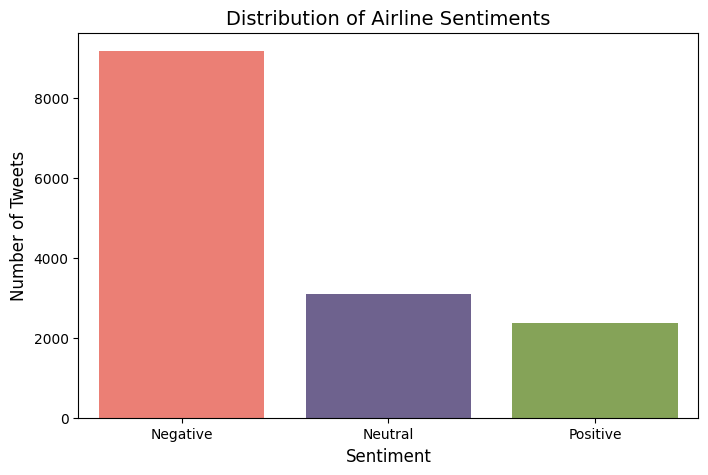

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment
sentiment_counts = data['airline_sentiment'].value_counts()

# Define new colors
colors = ["#FF6F61", "#6B5B95", "#88B04B"]  # Coral, Purple, Green

# Plot sentiment distribution with new colors
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)

# Label the plot
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.title("Distribution of Airline Sentiments", fontsize=14)
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

plt.show()


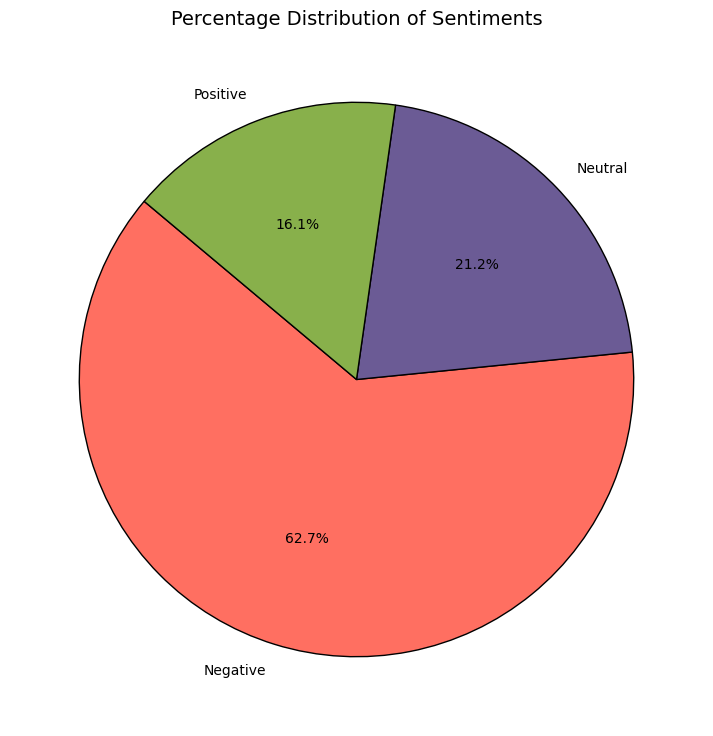

In [16]:
import matplotlib.pyplot as plt

# Calculate percentages
sentiment_percentages = (data['airline_sentiment'].value_counts(normalize=True) * 100).round(2)

# Define new light colors
light_colors = ["#FF6F61", "#6B5B95", "#88B04B"]  # Light Pink, Light Blue, Light Green

# Pie chart visualization
plt.figure(figsize=(9, 9))
plt.pie(sentiment_percentages, labels=['Negative', 'Neutral', 'Positive'],
        autopct='%1.1f%%', colors=light_colors, startangle=140, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Percentage Distribution of Sentiments", fontsize=14)

# Show the plot
plt.show()


In [17]:
# Display class distribution
sentiment_percentages = (data['airline_sentiment'].value_counts(normalize=True) * 100).round(2)
print("Sentiment Distribution:\n", sentiment_percentages)


Sentiment Distribution:
 airline_sentiment
negative    62.69
neutral     21.17
positive    16.14
Name: proportion, dtype: float64


In [18]:
# Sentiment class mapping
sentiment_mapping = {'positive': 1, 'negative': 0, 'neutral': 2}
data['sentiment_label'] = data['airline_sentiment'].map(sentiment_mapping)

In [19]:
data.head()

,text,airline_sentiment,sentiment_label
0,@VirginAmerica What @dhepburn said.,neutral,2
1,@VirginAmerica plus you've added commercials t...,positive,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


In [20]:
# Define text preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert to lowercase and process with spaCy
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatization and stopword removal
    return " ".join(words)

In [21]:

# Apply preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)
data.head()

,text,airline_sentiment,sentiment_label,clean_text
0,@VirginAmerica What @dhepburn said.,neutral,2,say
1,@VirginAmerica plus you've added commercials t...,positive,1,plus add commercial experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,2,today mean need trip
3,@VirginAmerica it's really aggressive to blast...,negative,0,aggressive blast obnoxious entertainment guest...
4,@VirginAmerica and it's a really big bad thing...,negative,0,big bad thing


In [ ]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['sentiment_label'], test_size=0.2, random_state=42)

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['sentiment_label'], test_size=0.2, random_state=42)

In [24]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
# Apply SMOTE to balance dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

In [26]:
# Hyperparameter tuning for Logistic Regression
param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [1000, 2000, 3000]}
grid_search_logreg = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid_logreg, cv=3, n_jobs=-1, verbose=1)
grid_search_logreg.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [1000, 2000, 3000],
                         'solver': ['liblinear', 'saga']},
             verbose=1)

In [27]:
# Train Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [29]:
# Train Naive Bayes
param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 2.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=3, n_jobs=-1, verbose=1)
grid_search_nb.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0]}, verbose=1)

In [30]:
# Get best models
best_logreg = grid_search_logreg.best_estimator_
best_rf = grid_search_rf.best_estimator_
best_nb = grid_search_nb.best_estimator_


In [31]:
# Predictions
y_pred_logreg = best_logreg.predict(X_test_tfidf)
y_pred_rf = best_rf.predict(X_test_tfidf)
y_pred_nb = best_nb.predict(X_test_tfidf)

In [32]:
# Model evaluation
accuracy_scores = {
    'Logistic Regression': accuracy_score(y_test, y_pred_logreg),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'Naive Bayes': accuracy_score(y_test, y_pred_nb)
}

In [33]:
# Show accuracy scores
for model, accuracy in accuracy_scores.items():
    print(f"{model} Accuracy: {accuracy:.4f}")

# Find the best model based on accuracy
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
print(f"Best model: {best_model_name}")

Logistic Regression Accuracy: 0.7497
Random Forest Accuracy: 0.7568
Naive Bayes Accuracy: 0.7380
Best model: Random Forest


In [34]:
# Prediction function
def predict_sentiment(text, model=best_model_name):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])

    if model == 'Logistic Regression':
        prediction = best_logreg.predict(vectorized_text)[0]
    elif model == 'Random Forest':
        prediction = best_rf.predict(vectorized_text)[0]
    else:
        prediction = best_nb.predict(vectorized_text)[0]

    sentiment_labels = {1: 'positive', 0: 'negative', 2: 'neutral'}
    return sentiment_labels[prediction]

In [35]:
# Test prediction
sample_text = "really missed a prime opportunity"
print(f'Sentiment of sample text: {predict_sentiment(sample_text)}')

Sentiment of sample text: neutral


In [36]:
# Save best model and vectorizer
joblib.dump(best_logreg, "/content/drive/MyDrive/Colab Notebooks/best_sentiment_model.pkl")
joblib.dump(vectorizer, "/content/drive/MyDrive/Colab Notebooks/tfidf_vectorizer.pkl")

# Load saved model and vectorizer
loaded_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/best_sentiment_model.pkl")
loaded_vectorizer = joblib.load("/content/drive/MyDrive/Colab Notebooks/tfidf_vectorizer.pkl")

In [37]:
# Function to predict sentiment using the saved model
def predict_sentiment_loaded(text, model=loaded_model):
    processed_text = preprocess_text(text)
    vectorized_text = loaded_vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]

    sentiment_labels = {1: 'positive', 0: 'negative', 2: 'neutral'}
    return sentiment_labels[prediction]

# Example usage
sample_text = "It is too late"
print(f'Sentiment of sample text (loaded model): {predict_sentiment_loaded(sample_text)}')


Sentiment of sample text (loaded model): negative


In [17]:
# Example usage
sample_text = "It is Good"
print(f'Sentiment of sample text (loaded model): {predict_sentiment_loaded(sample_text)}')

Sentiment of sample text (loaded model): positive


In [12]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.2 MB/s eta 0:00:00


In [13]:
# prompt: create streamlit code for above process. it should be pasted in app.py file. interface be like a text box and button named as "Calculate Sentiment"

import streamlit as st
import joblib
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Define text preprocessing function
def preprocess_text(text):
    doc = nlp(text.lower())  # Convert to lowercase and process with spaCy
    words = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatization and stopword removal
    return " ".join(words)

# Load the saved model and vectorizer
loaded_model = joblib.load("/content/drive/MyDrive/Colab Notebooks/best_sentiment_model.pkl")
loaded_vectorizer = joblib.load("/content/drive/MyDrive/Colab Notebooks/tfidf_vectorizer.pkl")

# Function to predict sentiment using the loaded model
def predict_sentiment_loaded(text, model=loaded_model):
    processed_text = preprocess_text(text)
    vectorized_text = loaded_vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]

    sentiment_labels = {1: 'positive', 0: 'negative', 2: 'neutral'}
    return sentiment_labels[prediction]

# Streamlit app
st.title("Sentiment Analysis App")

# Input text box
text_input = st.text_area("Enter text here:", "")

# Button to trigger prediction
if st.button("Calculate Sentiment"):
    if text_input:
        sentiment = predict_sentiment_loaded(text_input)
        st.write(f"Sentiment: {sentiment}")
    else:
        st.write("Please enter text to analyze.")


2025-03-10 15:52:50.473 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.617 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-10 15:52:50.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.624 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-10 15:52:50.626 Session state does not 

In [ ]:
# prompt: Exception has occurred: OSError
# [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.
#   File "C:\Users\Kajamalan\Desktop\Final\app.py", line 67, in <module>
#     nlp = spacy.load("en_core_web_sm")
#           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

!python -m spacy download en_core_web_sm


In [18]:
streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py

SyntaxError: invalid syntax (<ipython-input-18-fabc432b94c1>, line 1)